# Computer Vision with Oxford-IIIT Pet Dataset

## Data preparation

In [5]:
# Import dependencies

# PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets

try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
from torchinfo import summary

# Matplotlib
import matplotlib.pyplot as plt

# Pathlib
from pathlib import Path

# Timeit
from timeit import default_timer as timer

# tqdm
from tqdm.auto import tqdm

# Data structures
from typing import List, Tuple, Dict

# Pandas
import pandas as pd

# mlxtend and torchmetrics (for confusion matrix)
try:
  from torchmetrics import ConfusionMatrix # Calculates confusion matrix
  from mlxtend.plotting import plot_confusion_matrix # Plots confusion matrix
except:
  !pip install -q torchmetrics -U mlxtend
  from torchmetrics import ConfusionMatrix # Calculates confusion matrix
  from mlxtend.plotting import plot_confusion_matrix # Plots confusion matrix

# os
import os

In [6]:
## Check version
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [7]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() == True else "cpu"

In [8]:
# Get pretrained weights
weights = torchvision.models.ResNet34_Weights.DEFAULT # .DEFAULT = best available weights

auto_transforms = weights.transforms()
auto_transforms

data_path = Path("data/")
train_path = data_path / "train"
test_path = data_path / "test"

# Setup training data
if train_path.is_dir():
  print(f"{train_path} directory already exists, skipping download...")
else:
  print(f"{train_path} directory does not exist, downloading...")
  data_path.mkdir(parents=True, exist_ok=True)
  train_data = datasets.OxfordIIITPet(
      root="data",
      split="trainval",
      download=True,
      transform=auto_transforms,
      target_transform=None
  )

# Setup testing data
if test_path.is_dir():
  print(f"{test_path} directory already exists, skipping download...")
else:
  print(f"{test_path} directory does not exist, downloading...")
  test_data = datasets.OxfordIIITPet(
      root="data",
      split="test",
      download=True,
      transform=auto_transforms,
      target_transform=None
  )

data/train directory does not exist, downloading...


100%|██████████| 792M/792M [00:26<00:00, 29.4MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 12.6MB/s]


data/test directory does not exist, downloading...


In [9]:
# Check transforms
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [10]:
train_data

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: data
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

In [11]:
test_data

Dataset OxfordIIITPet
    Number of datapoints: 3669
    Root location: data
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

In [12]:
# Set class names
class_names = train_data.classes
class_names

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

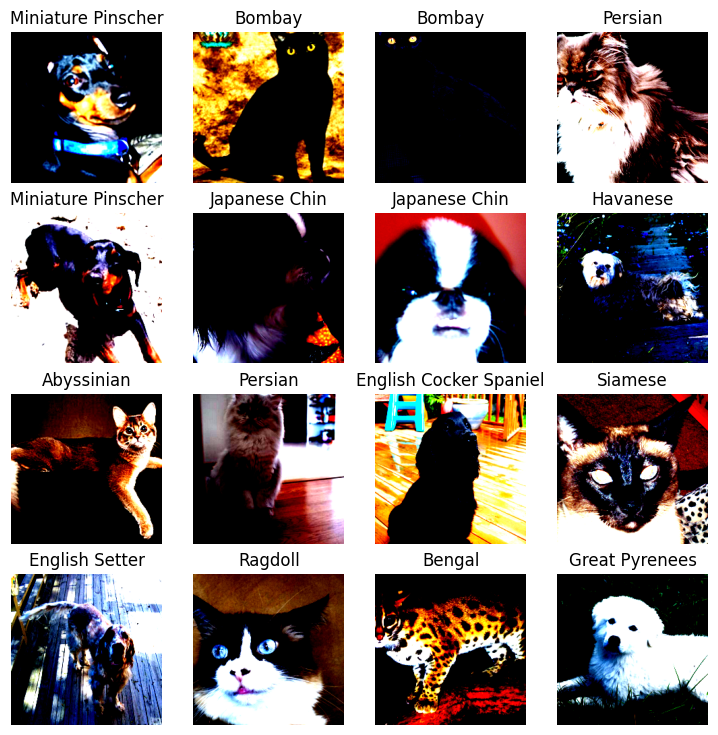

In [13]:
# Visualize a random image
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1,2,0))
  plt.title(class_names[label])
  plt.axis(False)

In [14]:
# Setup DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

len(train_dataloader), len(test_dataloader)

(115, 115)

In [15]:
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## Creating functions for training and testing loops (among other helper functions)

In [16]:
# Create training step
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  """Trains a model on a DataLoader"""
  # Put model into train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (back propagation)
    loss.backward()

    # Optimizer step (gradient descent)
    optimizer.step()

    # Calculate and accumulate accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [17]:
# Create testing step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  """Tests a model on a DataLoader"""
  # Setup model loss and accuracy values
  test_loss, test_acc = 0, 0

  # Set model to eval and inference mode
  model.eval()
  with torch.inference_mode():
    # Loop through data loader
    for batch, (X, y) in enumerate(dataloader):
      # Put data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate loss and accuracy
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()

      y_pred_classes = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      test_acc += torch.eq(y_pred_classes, y).sum().item()/len(y)

  # Calculate loss and accuracy per epoch
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)

  return test_loss, test_acc

In [18]:
# Create training function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int = 5,
          device=device):
  # Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through train and test steps
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)

    # Print out loss/accuracy development
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return results at the end of all epochs
  return results

In [19]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary"""
  # Get loss values of results dictionary
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get accuracy values of results dictionary
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs the model was trained on
  epochs = range(len(results["train_loss"]))

  # Setup a figure
  plt.figure(figsize=(10, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

In [29]:
def make_predictions(model: torch.nn.Module,
                    data_loader: torch.utils.data.DataLoader,
                    num_samples: int,
                    device="cpu"):
  """
  Produces a desired number of predictions from a model and data loader.

  Args:
    model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on.
    data_loader (torch.utils.data.DataLoader): A DataLoader instance for the model to be evaluated on.
    num_samples (int): The number of samples to predict on.
    device (str, optional): The target device to compute on. Defaults to "cpu".

  Returns:
    list: A list of predicted labels, alongside the actual labels and "raw" predictions
  """
  randomized_data_loader = DataLoader(
    dataset=data_loader.dataset,
    batch_size=data_loader.batch_size,
    shuffle=True
  )
  pred_labels = []
  test_labels = []
  test_samples = []
  model.eval()
  with torch.inference_mode():
      for X, y in randomized_data_loader:
          X, y = X.to(device), y.to(device)
          y_pred = model(X)
          # Store individual samples and predictions
          for i in range(X.shape[0]):
              test_samples.append(X[i].cpu()) # Store on CPU for plotting
              test_labels.append(y[i].cpu().unsqueeze(dim=0)) # Add a dimension to the label tensor
              pred_labels.append(y_pred[i].cpu().unsqueeze(dim=0)) # Add a dimension to the prediction tensor

              if len(test_samples) >= num_samples:
                  return pred_labels, test_labels, test_samples

In [36]:
def plot_predictions(model: torch.nn.Module,
                     data_loader: torch.utils.data.DataLoader,
                     num_samples: int=9,
                     device="cpu",
                     plot_worst: bool=False):
  """
  Plots a desired number of predictions from a model and data loader.

  Args:
    model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on.
    num_samples (int): The number of samples to predict on. Defaults to 9.
    data_loader (torch.utils.data.DataLoader): A DataLoader instance for the model to be evaluated on.
    device (str, optional): The target device to compute on. Defaults to "cpu".
    plot_worst (bool, optional): If True, plots the top num_samples worst predictions. Defaults to False.
  """
  # Ensure model only has to go through all predictions if it's finding the worst
  num_test_images = len(data_loader.dataset) if plot_worst else num_samples
  pred_labels, test_labels, test_samples = make_predictions(model=model,
                                                            data_loader=data_loader,
                                                            num_samples=num_test_images,
                                                            device=device)

  if plot_worst:
      # Identify incorrect predictions and their probabilities
      incorrect_predictions = []
      for i in range(len(pred_labels)):
          pred_label_idx = torch.argmax(pred_labels[i])
          if pred_label_idx != test_labels[i]:
              incorrect_predictions.append({
                  "image": test_samples[i],
                  "predicted_prob": torch.max(torch.softmax(pred_labels[i], dim=1)),
                  "predicted_label": class_names[pred_label_idx],
                  "true_label": class_names[test_labels[i]]
              })

      # Sort incorrect predictions by predicted probability in descending order
      incorrect_predictions.sort(key=lambda x: x["predicted_prob"], reverse=True)

      # Select the top num_samples worst predictions
      predictions_to_plot = incorrect_predictions[:num_samples]

  else:
      # If not plotting worst, shuffle and select random samples
      indices = torch.randperm(len(test_samples))[:num_samples]
      predictions_to_plot = []
      for i in indices:
          pred_label_idx = torch.argmax(pred_labels[i])
          predictions_to_plot.append({
              "image": test_samples[i],
              "predicted_prob": torch.max(torch.softmax(pred_labels[i], dim=1)),
              "predicted_label": class_names[pred_label_idx],
              "true_label": class_names[test_labels[i]]
          })


  plt.figure(figsize=(9, 9))
  nrows = int(num_samples**0.5) # Simple way to get roughly square grid
  ncols = int(num_samples**0.5) + (num_samples % int(num_samples**0.5) != 0)

  for i in range(len(predictions_to_plot)):
      prediction_data = predictions_to_plot[i]
      sample = prediction_data["image"]
      pred_label = prediction_data["predicted_label"]
      true_label = prediction_data["true_label"]
      predicted_prob = prediction_data["predicted_prob"]

      # Create subplot
      plt.subplot(nrows, ncols, i+1)

      # Plot the target image, permuting dimensions for matplotlib
      plt.imshow(sample.permute(1, 2, 0))

      # Create a title for the plot
      title_text = f"Pred: {pred_label} ({predicted_prob:.3f}) | Truth: {true_label}"

      # Check for equality between pred and truth and change color of title text
      if pred_label == true_label:
        plt.title(title_text, fontsize=10, c="g")
      else:
        plt.title(title_text, fontsize=10, c="r")
      plt.axis(False)

  plt.tight_layout()
  plt.show()

In [22]:
def plot_conf_matrix(model: torch.nn.Module,
                          data_loader: torch.utils.data.DataLoader,
                          class_names: List[str],
                          device="cpu"):
  """
  Plots a confusion matrix for a trained model and data loader.

  Args:
    model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on.
    class_names (List): A list of class names for the model.
    data_loader (torch.utils.data.DataLoader): A DataLoader instance for the model to be evaluated on.
    device (str, optional): The target device to compute on. Defaults to "cpu".
  """
  pred_labels, test_labels, test_samples = make_predictions(model=model,
                                                            data_loader=data_loader,
                                                            num_samples=len(data_loader.dataset),
                                                            device=device) # Get predictions for all samples
  # Get prediction labels into tensor format (from list)
  y_pred_tensor = torch.cat(pred_labels)
  y_labels_tensor = torch.cat(test_labels)

  # Convert prediction probabilities to predicted class indices
  y_pred_classes = torch.argmax(y_pred_tensor, dim=1)

  # Setup confusion instance and compare predicts to targets
  confmat = ConfusionMatrix(num_classes=len(class_names),
                            task="multiclass")

  confmat_tensor = confmat(preds=y_pred_classes,
                          target=y_labels_tensor.squeeze()) # Remove the extra dimension from labels

  # Plot confusion matrix
  fix, ax = plot_confusion_matrix(
      conf_mat=confmat_tensor.numpy(),
      class_names=class_names,
      figsize=(10, 7)
  )

In [23]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_dir: str,
                        class_names: List[str]=None,
                        transform=None,
                        device=device):
  """
  Plots a confusion matrix for a trained model and data loader.

  Args:
    model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on.
    image_dir (str): A directory of images to predict on.
    class_names (List): A list of class names for the model.
    transform (optional): A transformation to be applied to the image. Must match the one used for training the model.
    device (str, optional): The target device to compute on. Defaults to "cpu".
  """
  num_images = len(list(Path(CLASSIFICATION_PATH / "custom_images").iterdir()))
  nrows = int(num_images**0.5) # Simple way to get roughly square grid
  ncols = int(num_images**0.5) + (num_images % int(num_images**0.5) != 0)
  plt.figure(figsize=(9, 9))

  for root, dirs, files in os.walk(image_dir):
    for i, file in enumerate(files):
      image_path = image_dir / file
      # Load in the image in uint8
      target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

      # Divide the image pixel values to get them between [0, 1]
      target_image /= 255

      # Transform the image
      if transform:
        target_image = transform(target_image)

      # Make sure the model is on the target device and image are on the target device
      model.to(device)
      target_image = target_image.to(device)

      # Turn the target image to a batch of size 1
      target_image = target_image.unsqueeze(dim=0)

      # Turn on eval/inference mode and make a prediction
      model.eval()
      with torch.inference_mode():
        # Make a prediction on the image
        target_image_pred_logits = model(target_image)

      # Convert logits to prediction probabilities
      target_image_pred_probs = torch.softmax(target_image_pred_logits, dim=1)

      # Convert prediction probabilities to prediction labels
      target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

      # Plot the image
      plt.subplot(nrows, ncols, i+1)
      plt.imshow(target_image.squeeze().permute(1, 2, 0).cpu())
      if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
      else:
        title = f"Pred: {target_image_pred_label.cpu()} | Prob: {target_image_pred_probs.max().cpu():.3f}"
      plt.title(title)
      plt.axis(False)

## Transfer learning using ResNet34

In [24]:
class ResNet34(torch.nn.Module):
    def __init__(self, weights, freeze_weights, dropout):
        super().__init__()
        # Load the ResNet model
        resnet = torchvision.models.resnet34(weights=weights)
        out_features = 512

        # Freezing the weights
        if freeze_weights:
            for param in resnet.parameters():
                param.requires_grad = False

        # Overwright classifier layer
        base_model = nn.Sequential(*list(resnet.children())[:-1]) # Saves all layers except for the last

        self.layers = nn.Sequential(
            base_model,
            nn.Flatten(),
            nn.Linear(out_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 37)
        )

    def forward(self, x):
        outputs = self.layers(x)
        return outputs

### Download model state dictionary

In [25]:
# Create Oxford-IIIT-Classification path if it doesn't already exist
CLASSIFICATION_PATH = Path("Oxford-IIIT-Classification")

# Get repository containing weights and custom images
if not CLASSIFICATION_PATH.is_dir():
  print("Directory not found, cloning GitHub repository...")
  ! git clone https://github.com/brooks-coding/Oxford-IIIT-Classification.git
  print("Repository cloned successfully.")
else:
  print("Directory already exists, skipping cloning.")

Directory not found, cloning GitHub repository...
Cloning into 'Oxford-IIIT-Classification'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 49 (delta 5), reused 26 (delta 4), pack-reused 21 (from 1)
Receiving objects: 100% (49/49), 80.21 MiB | 23.12 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Encountered 1 file(s) that should have been pointers, but weren't:
	models/pytorch_Oxford_IIIT_ResNet34.pth
Repository cloned successfully.


In [26]:
# Set hyperparameters
DROPOUT = 0.4
NUM_EPOCHS = 5

# Instantiate model
model_ResNet34 = ResNet34(
    weights=weights,
    freeze_weights=True,
    dropout=DROPOUT
).to(device)

summary(model=model_ResNet34,
        input_size=(32, 3, 224, 224), # Create a forward pass for image of target size
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 154MB/s]


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResNet34 (ResNet34)                                [32, 3, 224, 224]    [32, 37]             --                   Partial
├─Sequential (layers)                              [32, 3, 224, 224]    [32, 37]             --                   Partial
│    └─Sequential (0)                              [32, 3, 224, 224]    [32, 512, 1, 1]      --                   False
│    │    └─Conv2d (0)                             [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    │    └─BatchNorm2d (1)                        [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    │    └─ReLU (2)                               [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    │    └─MaxPool2d (3)                          [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    │    └─Sequential (4)            

In [27]:
# Training and evaluation
import os
from pathlib import Path
import requests
import time

# Define the model file name and full save path
MODEL_NAME = "models/pytorch_Oxford_IIIT_ResNet34.pth"
ResNet34_SAVE_PATH = CLASSIFICATION_PATH / MODEL_NAME

# Check if the model state dictionary file already exists
if ResNet34_SAVE_PATH.is_file():
    print(f"'{MODEL_NAME}' already saved locally, skipping download and training...")
    model_ResNet34.load_state_dict(torch.load(ResNet34_SAVE_PATH))
    model_ResNet34.eval()
else:
    # If the download fails, print an error and then proceed with training
    print(f"Download failed, training '{MODEL_NAME}' now...")

    # Setup loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model_ResNet34.parameters(),
                                  lr=0.001)

    # Start timer
    start_time = timer()

    # Train model
    model_ResNet34_results = train(model=model_ResNet34,
                                    train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    epochs=NUM_EPOCHS)

    # End timer
    end_time = timer()
    print(f"Total training time: {end_time-start_time:.3f} seconds")
    plot_loss_curves(model_ResNet34_results)

'models/pytorch_Oxford_IIIT_ResNet34.pth' already saved locally, skipping download and training...


### Model testing with test set

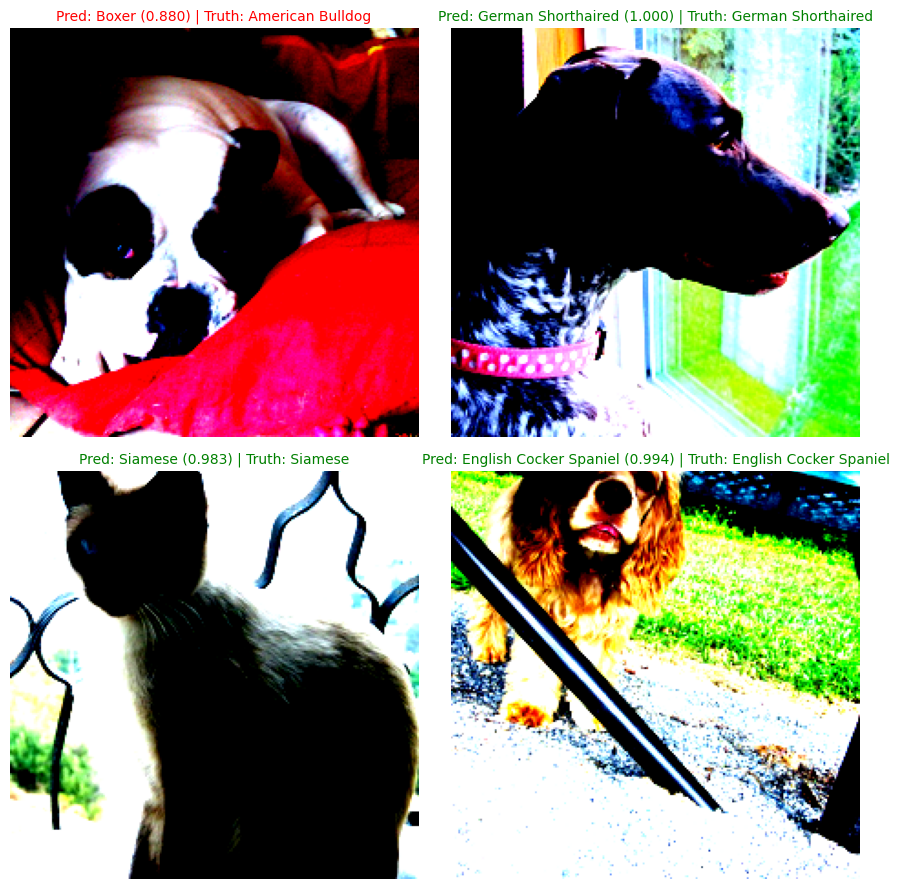

In [49]:
# Plot 9 random predictions
plot_predictions(model=model_ResNet34,
                 data_loader=test_dataloader,
                 num_samples=4,
                 device=device,
                 plot_worst=False)

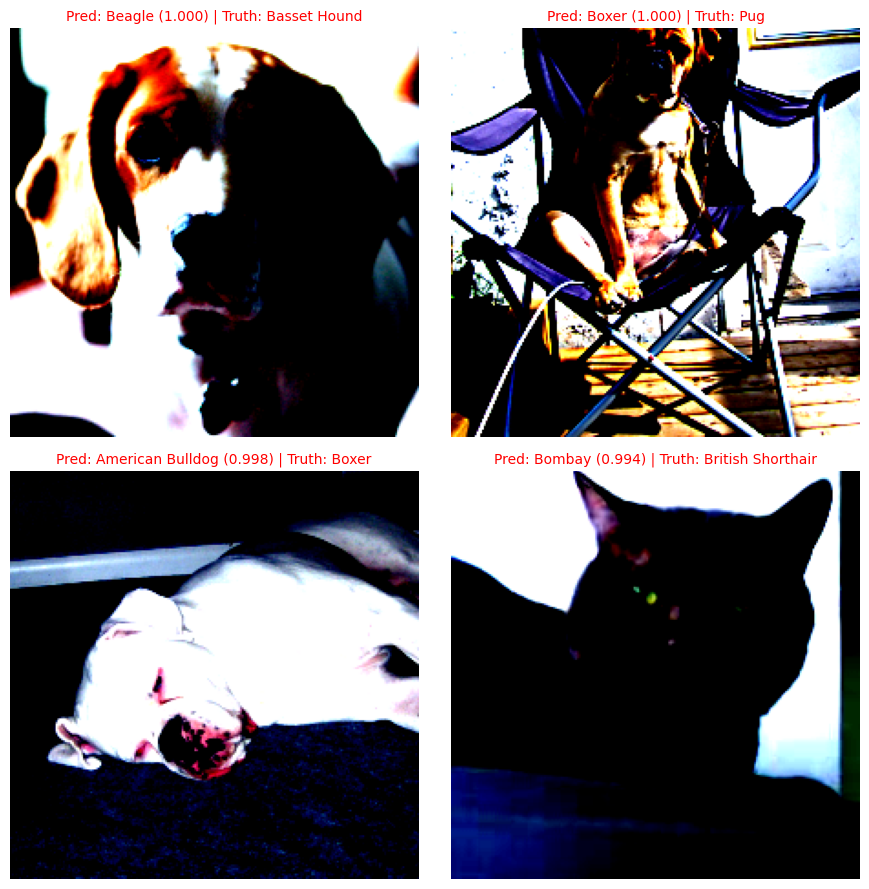

In [38]:
# Plot top 4 worst predictions
plot_predictions(model=model_ResNet34,
                 data_loader=test_dataloader,
                 num_samples=4,
                 device=device,
                 plot_worst=True)

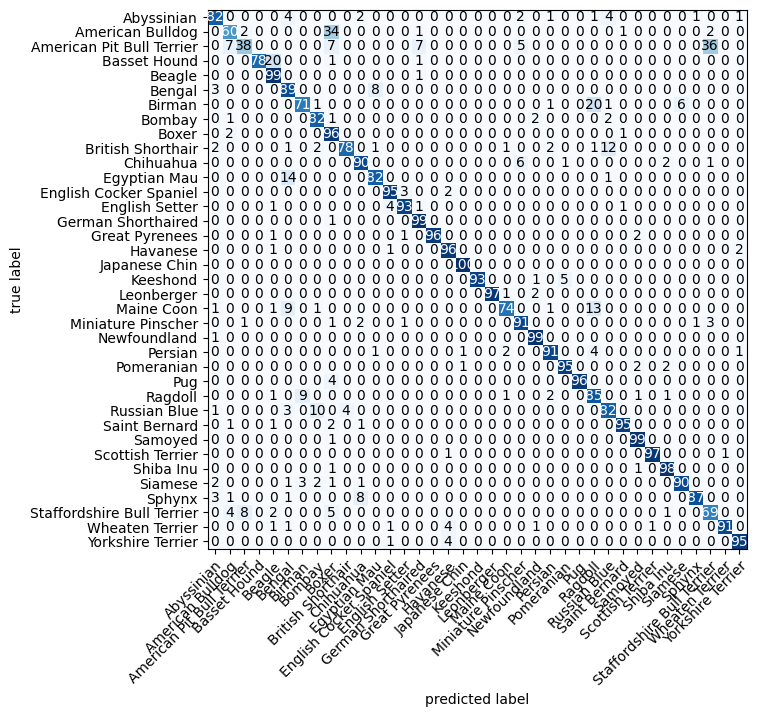

In [33]:
plot_conf_matrix(model=model_ResNet34,
                data_loader=test_dataloader,
                class_names=class_names,
                device=device)

### Model testing with custom image

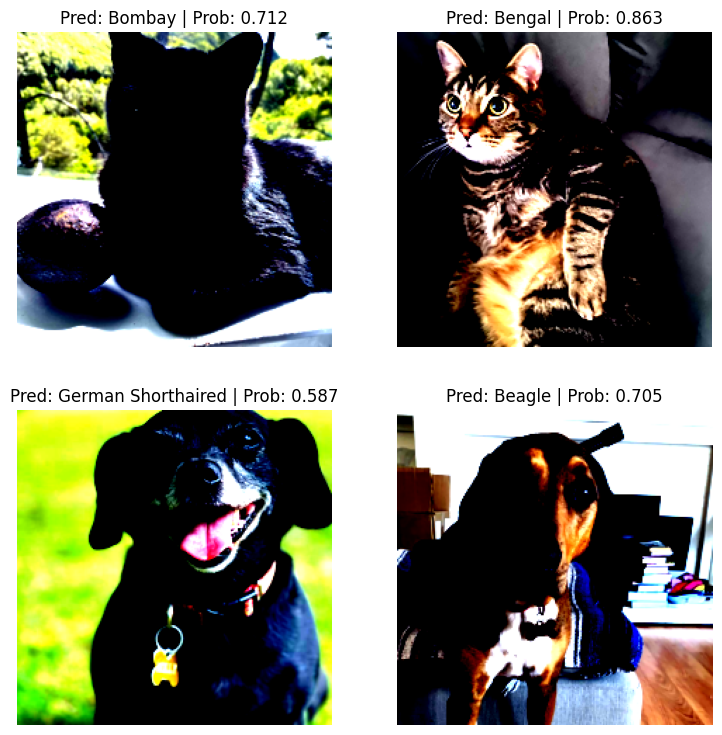

In [31]:
CUSTOM_IMAGES_PATH = CLASSIFICATION_PATH / "custom_images"
pred_and_plot_image(model=model_ResNet34,
                    image_dir=CUSTOM_IMAGES_PATH,
                    class_names=class_names,
                    transform=auto_transforms,
                    device=device)